<a href="https://colab.research.google.com/github/eringgao/githubTest/blob/master/Copy_of_goal3_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow
!pip install wandb
!pip install tf_explain
!pip install lime

In [14]:
import sys
sys.dont_write_bytecode = True

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [15]:
!cp '/content/drive/My Drive/import_modules.py' /content
import import_modules
from import_modules import *

In [ ]:
!unzip /content/drive/My\ Drive/new_validation_data_merced_update.zip -d /
!unzip /content/drive/My\ Drive/new_all_training_data_merced_update.zip -d /
!unzip /content/drive/My\ Drive/new_linear_bias_data_merced_update.zip -d /
!mkdir /content/models
!mkdir /content/models/AutoEncoder
!unzip /content/drive/My\ Drive/UCMerced_LandUse.zip -d /content/data

In [44]:
##################
### == GOAL == ###
##################


def trainNewEncoder(root_dir, val_dir) :

  MODEL_NAME = "AutoEncoder"
  OUTPUT_MODEL_PATH = '/content/models' + MODEL_NAME

  NUM_EPOCHS = 2 #400
  BATCH_SIZE = 64
  VERBOSE = 1

  dims = (256, 256, 3) 

  img_paths = getPathsOfData([root_dir])
  val_img_paths = getPathsOfData([val_dir])
  print("len(img_paths):", len(img_paths))
  print("len(val_img_paths):", len(val_img_paths))

  X_train_paths = img_paths
  X_valid_paths = val_img_paths

  AUTOTUNE = tensorflow.data.experimental.AUTOTUNE

  train_dataset = tf.data.Dataset.from_generator(generator=customGenerator, 
                                                 output_types=(np.float32, np.float32), 
                                                 output_shapes=(dims, dims), 
                                                 args=[X_train_paths, dims, "png"])
  
  valid_dataset = tf.data.Dataset.from_generator(generator=customGenerator, 
                                                 output_types=(np.float32, np.float32), 
                                                 output_shapes=(dims, dims), 
                                                 args=[X_valid_paths, dims, "png"])

  output = list(train_dataset.take(1).as_numpy_iterator())
  x,y = output[0]

  def convert(image, label):
    image = tensorflow.image.convert_image_dtype(image, tf.float32)
    label = tensorflow.image.convert_image_dtype(label, tf.float32)
    return image, label

  def augment(image,label):
    image = tf.image.rot90(image, random.randint(0,3))
    #print(image.shape)
    #image = tf.keras.preprocessing.image.random_rotation(image, 360, row_axis=0, col_axis=1, channel_axis=2)#, row_axis=1, col_axis=2, channel_axis=0, fill_mode='nearest', cval=0.0, interpolation_order=1)
    if random.randint(0,1) == 1:
      image = tf.image.flip_left_right(image)
    if random.randint(0,1) == 1:
      image = tf.image.flip_up_down(image)
    if random.randint(0,1) == 1:
      image = tf.image.random_brightness(image, max_delta=0.1)
    if random.randint(0,1) == 1:
      val = float(random.randint(90, 100)) / 100
      image = tf.image.adjust_contrast(image, val)
    if random.randint(0,1) == 1:
      image = tf.image.random_hue(image, max_delta=0.1)
    if random.randint(0,1) == 1:
      image = tf.image.random_saturation(image, lower=0.45, upper=0.55)
    return image, image


  train_dataset = train_dataset.map(convert, num_parallel_calls=AUTOTUNE)
  train_dataset = train_dataset.cache()
  train_dataset = train_dataset.map(augment, num_parallel_calls=AUTOTUNE)
  train_dataset = train_dataset.shuffle(buffer_size=3*BATCH_SIZE, reshuffle_each_iteration=False)
  train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=False)
  train_dataset = train_dataset.repeat()
  train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

  valid_dataset = valid_dataset.map(convert, num_parallel_calls=AUTOTUNE)
  valid_dataset = valid_dataset.cache()
  valid_dataset = valid_dataset.shuffle(buffer_size=3*BATCH_SIZE, reshuffle_each_iteration=False)
  valid_dataset = valid_dataset.batch(BATCH_SIZE, drop_remainder=False)
  valid_dataset = valid_dataset.repeat()
  valid_dataset = valid_dataset.prefetch(buffer_size=AUTOTUNE)

  #output = list(train_dataset.take(1).as_numpy_iterator())
  #x,y = output[0]
  #for i in range(4):
  #  plt.figure()
  #  plt.imshow(x[i, :, :, :])
  #  plt.show()

  wandb.init(project = 'autoencoder')
  config = wandb.config
  config.learning_rate = 0.001

  try:
      del complete_model
  except:
      pass
  complete_model = createReLUModel2(dims)
  #complete_model = createMicroModel(dims)
  complete_model.summary()
  

  image = resize(plt.imread(X_train_paths[0])[:,:,:3], dims)
  #print("Activation visualization image shape orig:", image.shape)
  image = np.expand_dims(image, 0)
  #print("Activation visualization image shape extended:", image.shape)
  #print("image:", image.min(), image.max())

  # callback function to save after every 10 epochs
  #ckpt_path = OUTPUT_MODEL_PATH + "/checkpoints/"
  #subprocess.call("mkdir -p %s" % ckpt_path, shell=True)
  #model_ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
  #    filepath=ckpt_path + "epoch{epoch:03d}-loss{loss:.6f}.hdf5",
  #    monitor='val_acc', verbose=VERBOSE, save_best_only=True,
  #    save_weights_only=False, mode='auto')

  earlystopping_callback = tf.keras.callbacks.EarlyStopping(
      monitor='val_loss', min_delta=0.015, patience=25, verbose=1, mode='auto', baseline=0.9, restore_best_weights = True) 

  callback_functions = [earlystopping_callback, WandbCallback()] 



  opt = tf.keras.optimizers.Adam(learning_rate=0.001)
  complete_model.compile(optimizer=opt, loss='mse')#loss=ssim_loss_ms)

  model_history = complete_model.fit(train_dataset,
                                     epochs=NUM_EPOCHS,
                                     batch_size=BATCH_SIZE,
                                     steps_per_epoch=len(X_train_paths) // BATCH_SIZE,
                                     initial_epoch=0,
                                     callbacks=callback_functions,  
                                     validation_data=valid_dataset,
                                     validation_steps=len(X_valid_paths) // BATCH_SIZE, 
                                     verbose=1)

  showReconstruction(complete_model, root_dir, 9, dims)

  toReturn = -12 #-8 #-16, -21, -14, -3
  return Model(complete_model.input, complete_model.layers[toReturn].output)

In [41]:
def convert(image, label):
    image = tensorflow.image.convert_image_dtype(image, tf.float32) 
    label = tensorflow.image.convert_image_dtype(label, tf.float32)
    return image, label

def ssim_loss(y_true, y_pred):
    loss=tf.reduce_mean(tf.image.ssim(y_true,y_pred,1.0,filter_size=3))
    return 1-loss
def ssim_loss_ms(y_true, y_pred):
    loss=tf.reduce_mean(tf.image.ssim_multiscale(y_true,y_pred,1.0,filter_size=3))
    return 1-loss

def customGenerator(input_file_paths, dims, data_type):
    for i, file_path in enumerate(input_file_paths):
        if data_type.decode("utf-8") in ["png" or "tif"]:
            img = plt.imread((file_path.decode("utf-8")))
        elif data_type.decode("utf-8") == "npy":
            img = np.load(file_path.decode("utf-8"))
        x = resize(img[:,:,:3], dims)           
        yield x, x

def getPathsOfData(roots) :
    img_dirs = []
    for root in roots :
        path, dirs, files = next(os.walk(root))
        for file_dir in files :
            if file_dir[-3:] == 'tif' :
              img_dirs.append(path + '/' + file_dir)
        for dir in dirs :
            img_subdirs = getPathsOfData([path + '/' + dir])
            for subdir in img_subdirs :
                img_dirs.append(subdir)
    return img_dirs

def getClassColors(filenames) :
    color_ids = []
    classes = []
    for name in filenames :
        class_name = name[name.rindex('/') + 1:-6]
        classes.append(class_name)
        try :
            ind = classes.index(class_name)
            color_ids.append(color_ids[ind])
        except:
            r = random.randint(40, 210) / 255
            g = random.randint(40, 210) / 255
            b = random.randint(40, 210) / 255
            color_ids.append([r, g, b])
    return color_ids


def showReconstruction(complete_model, imgs_root, num, dims) :
    X_train_paths = getPathsOfData([imgs_root])
    for i in range(num):
        index = np.random.randint(0, len(X_train_paths))

        image_train = resize(plt.imread(X_train_paths[index])[:,:,:3], dims)
        X_image_train = np.expand_dims(image_train, 0)
        out_image = np.squeeze(complete_model.predict(X_image_train))

        toReturn = -12
        encoder = Model(complete_model.input, complete_model.layers[toReturn].output)
        #encoder.summary()
        #activation_temp = encoder.predict(X_image_train)#.max(axis=-1)
        #print(activation_temp.shape)
        activation_output = encoder.predict(X_image_train).max(axis=-1) #(x, x, 1) --> (1, 64, 64)
        activation_output = np.squeeze(activation_output)

        toReturn = -14
        encoder = Model(complete_model.input, complete_model.layers[toReturn].output)
        #encoder.summary()

        activation_output_2 = encoder.predict(X_image_train).max(axis = -1)
        activation_output_2 = np.squeeze(activation_output_2)

        activation_output_4 = encoder.predict(X_image_train).mean(axis = -1)
        activation_output_4 = np.squeeze(activation_output_4)

        toReturn = -16
        encoder = Model(complete_model.input, complete_model.layers[toReturn].output)
        #encoder.summary()

        activation_output_3 = encoder.predict(X_image_train).max(axis = -1)

        #activation_output_2 = encoder.predict(X_image_train).mean(axis = -1)
        activation_output_3 = np.squeeze(activation_output_3)


        #print(activation_output.shape)
        out_image_2 = activation_output
        out_image_3 = activation_output_2
        out_image_4 = activation_output_3
        out_image_5 = activation_output_4

        #out_image_2 = np.squeeze(complete_model.predict(X_image_train))


        im_min = out_image.min(axis=(0, 1), keepdims=True)
        im_max = out_image.max(axis=(0, 1), keepdims=True)
        out_image = (out_image - im_min) / (im_max - im_min)

        im_min_2 = out_image_2.min(axis=(0, 1), keepdims=True)
        im_max_2 = out_image_2.max(axis=(0, 1), keepdims=True)
        out_image_2 = (out_image_2 - im_min_2) / (im_max_2 - im_min_2)

        im_min_3 = out_image_3.min(axis=(0, 1), keepdims=True)
        im_max_3 = out_image_3.max(axis=(0, 1), keepdims=True)
        out_image_3 = (out_image_3 - im_min_3) / (im_max_3 - im_min_3)

        im_min_4 = out_image_4.min(axis=(0, 1), keepdims=True)
        im_max_4 = out_image_4.max(axis=(0, 1), keepdims=True)
        out_image_4 = (out_image_4 - im_min_4) / (im_max_4 - im_min_4)

        im_min_5 = out_image_5.min(axis=(0, 1), keepdims=True)
        im_max_5 = out_image_5.max(axis=(0, 1), keepdims=True)
        out_image_5 = (out_image_5 - im_min_5) / (im_max_5 - im_min_5)

        #print("Orig ", np.min(X_image_train), np.max(X_image_train))
        print("Gen ", np.min(out_image), np.max(out_image))
        #    fig = plt.figure(figsize = (18, 14))

        fig = plt.figure(figsize = (25, 25))
        plt.subplot(1, 7, 1)
        #pltname = X_train_paths[index][X_train_paths.rindex('/') + 1:-4] #sample_similar[i][j][sample_similar[i][j].rindex('/') + 1:-4]
        plt.imshow(image_train)
        plt.subplot(1, 7, 2)
        plt.imshow(out_image)
        plt.subplot(1, 7, 3)
        plt.title('max -12')
        plt.imshow(out_image_2)
        plt.subplot(1, 7, 4)
        plt.title('max -14')
        plt.imshow(out_image_3)
        plt.subplot(1, 7, 5)
        plt.title('max -16')
        plt.imshow(out_image_4)
        plt.subplot(1, 7, 6)
        plt.title('average -12')
        plt.imshow(out_image_5)
        plt.savefig("check.png")
        plt.show()

def createSubsizedDataset(dataset_dir, num_classes, val_percent, balanced_percent) :
    # first create all folders to be put in
      # UC_num_classes (/content/data/UC_5)
        #full_train (balanced training portion of code, validation is taken out and placed into val)
        #biased_train (takes full_train and applies a linear bias to if making a balanced percent)
        #val
    subsize_root = '/content/data/UC_' + str(num_classes)
    shutil.rmtree(subsize_root, ignore_errors = True)
    os.mkdir(subsize_root)    
    os.mkdir(subsize_root + '/full_train')
    os.mkdir(subsize_root + '/biased_train')
    os.mkdir(subsize_root + '/val')

    # get random class names and add subfolders
    _, all_classes, _ = next(os.walk(dataset_dir))
    subsize_classes = random.sample(all_classes, num_classes)
    for folder in ['full_train', 'biased_train', 'val'] :
        for name in subsize_classes :
            os.mkdir(subsize_root + '/' + folder + '/' + name)

    # copy selected classes from dataset to full_train
    for name in subsize_classes :
        _, _, files = next(os.walk(dataset_dir + '/' + name))
        files.sort()
        for fileName in files :
            dirInFull = dataset_dir + '/' + name + '/' + fileName
            dirInSubsize = subsize_root + '/full_train/' + name + '/' + fileName
            copyfile(dirInFull, dirInSubsize)

    # for each selected class, cut val_percent from each of them in full_train and paste to biased_train
    fullTrain_root = subsize_root + '/full_train'
    val_root = subsize_root + '/val'
    for name in subsize_classes :
        _, _, files = next(os.walk(fullTrain_root + '/' + name))
        val_files = random.sample(files, int(val_percent * len(files)))
        for fileName in val_files :
            dirInTrain = fullTrain_root + '/' + name + '/' + fileName
            dirInSubsize = val_root + '/' + name + '/' + fileName
            copyfile(dirInTrain, dirInSubsize)
            os.remove(dirInTrain)             

    # create biased_train set from full_train set


In [42]:
def createMicroModel(dims) :
    complete_model = Sequential(name="complete_model")
    complete_model.add(Input(shape=dims))
    complete_model.add(Conv2D(10, (3, 3), padding="same", strides=2))
    complete_model.add(ReLU())
    complete_model.add(Conv2D(2, (3, 3), padding="same", strides=2))
    complete_model.add(ReLU())
    #complete_model.add(tf.keras.layers.Flatten())
    #complete_model.add(tf.keras.layers.Dense(1024))
    #complete_model.add(tf.keras.layers.Reshape((32, 32, 1)))
    complete_model.add(UpSampling2D((2, 2)))
    complete_model.add(Conv2DTranspose(2, (3, 3), padding="same"))
    complete_model.add(ReLU())
    complete_model.add(UpSampling2D((2, 2)))
    complete_model.add(Conv2DTranspose(10, (3, 3), padding="same"))
    complete_model.add(ReLU())
    complete_model.add(Conv2DTranspose(3, (3, 3), padding="same"))
    return complete_model
 
def createReLUModel2(dims) :
    complete_model = Sequential(name="complete_model")
    complete_model.add(Input(shape=dims))
    complete_model.add(Conv2D(32, (3, 3), padding="same", strides=2))
    #complete_model.add(tf.keras.layers.BatchNormalization())
    complete_model.add(ReLU())
    complete_model.add(Conv2D(48, (3, 3), padding="same", strides=2))
    #complete_model.add(tf.keras.layers.BatchNormalization())
    complete_model.add(ReLU())
    complete_model.add(Conv2D(72, (3, 3), padding="same", strides=2))
    complete_model.add(ReLU())
    complete_model.add(Conv2D(108, (3, 3), padding="same", strides=2))
    complete_model.add(ReLU())
    complete_model.add(Conv2D(32, (3, 3), padding="same"))
    complete_model.add(ReLU())
    complete_model.add(Conv2D(8, (3, 3), padding="same"))
    complete_model.add(ReLU())
    #complete_model.add(tf.keras.layers.Flatten())
    #complete_model.add(tf.keras.layers.Dense(1024))
    #complete_model.add(tf.keras.layers.Reshape((32, 32, 1)))
    complete_model.add(Conv2DTranspose(32, (3, 3), padding="same", strides = (2,2)))
    complete_model.add(ReLU())
    #complete_model.add(UpSampling2D((2, 2)))
    complete_model.add(Conv2DTranspose(108, (3, 3), padding="same", strides = (2,2)))
    complete_model.add(ReLU())
    #complete_model.add(UpSampling2D((2, 2)))
    complete_model.add(Conv2DTranspose(72, (3, 3), padding="same", strides = (2,2)))
    complete_model.add(ReLU())
    #complete_model.add(UpSampling2D((2, 2)))
    complete_model.add(Conv2DTranspose(48, (3, 3), padding="same", strides = (2,2)))
    complete_model.add(ReLU())
    #complete_model.add(UpSampling2D((2, 2)))
    complete_model.add(Conv2DTranspose(32, (3, 3), padding="same"))
    complete_model.add(ReLU())
    complete_model.add(Conv2DTranspose(3, (3, 3), padding="same"))
    return complete_model

len(img_paths): 1260
len(val_img_paths): 210
(256, 256, 3)


Model: "complete_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
re_lu_55 (ReLU)              (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 64, 64, 48)        13872     
_________________________________________________________________
re_lu_56 (ReLU)              (None, 64, 64, 48)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 32, 32, 72)        31176     
_________________________________________________________________
re_lu_57 (ReLU)              (None, 32, 32, 72)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 16, 16, 108)    

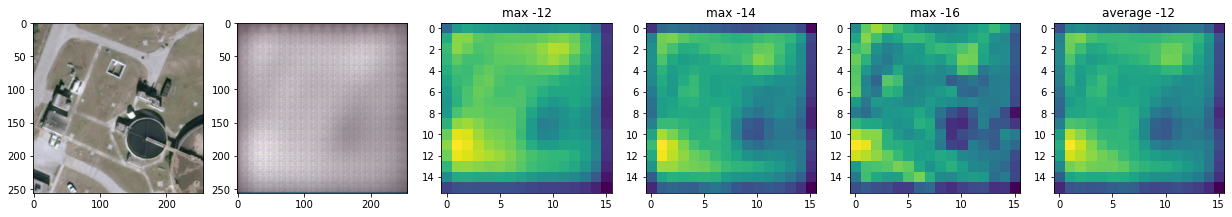

Gen  0.0 1.0


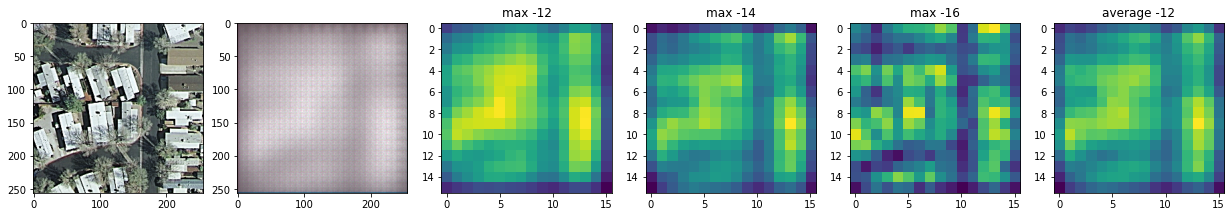

Gen  0.0 1.0


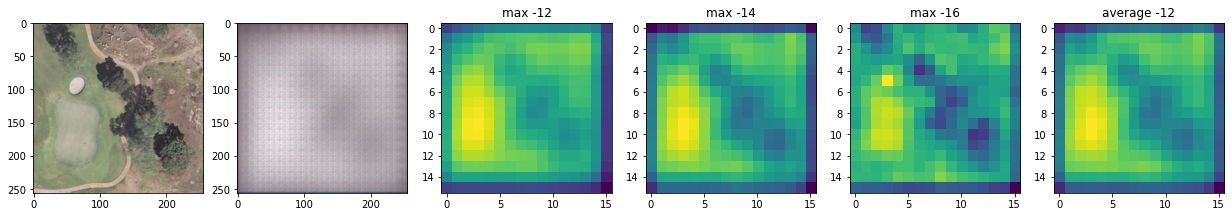

Gen  0.0 1.0


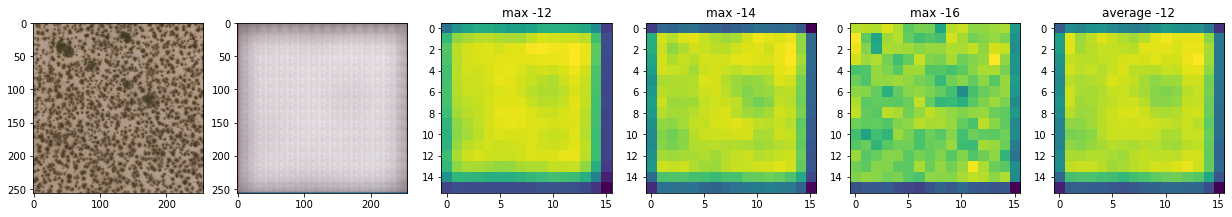

Gen  0.0 1.0


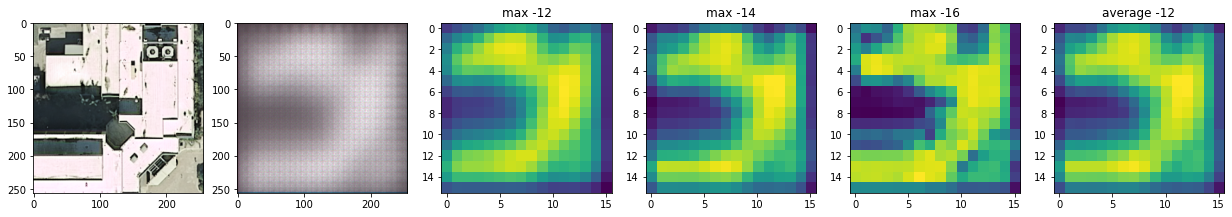

Gen  0.0 1.0


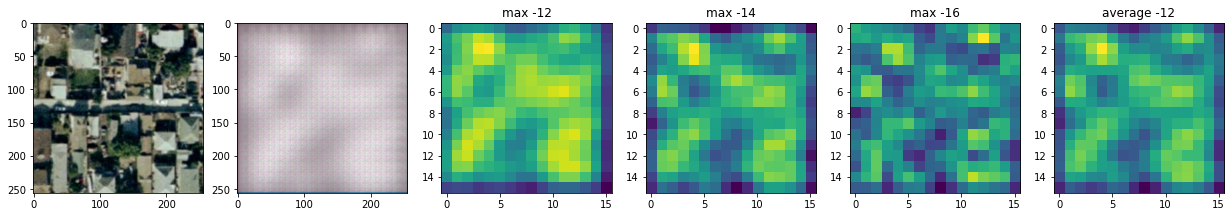

Gen  0.0 1.0


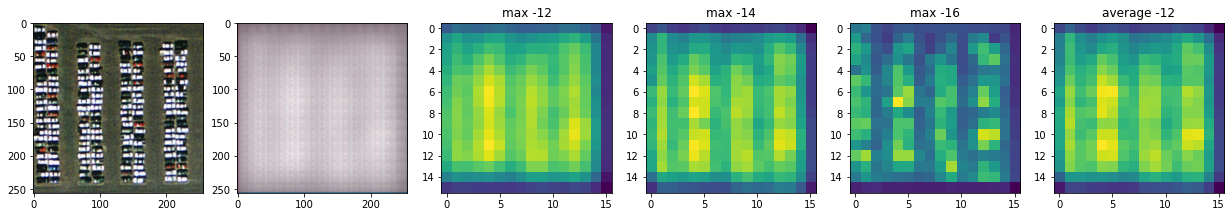

Gen  0.0 1.0


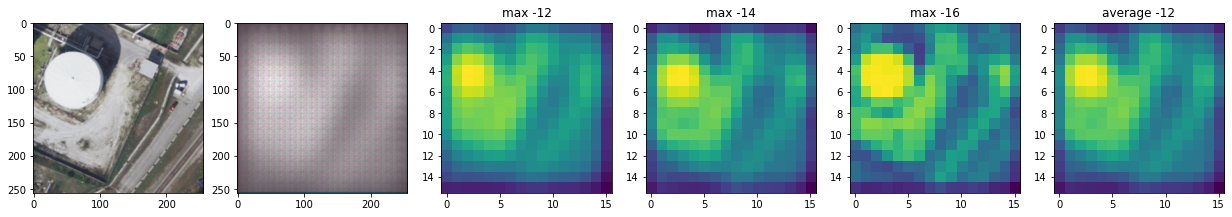

Gen  0.0 1.0


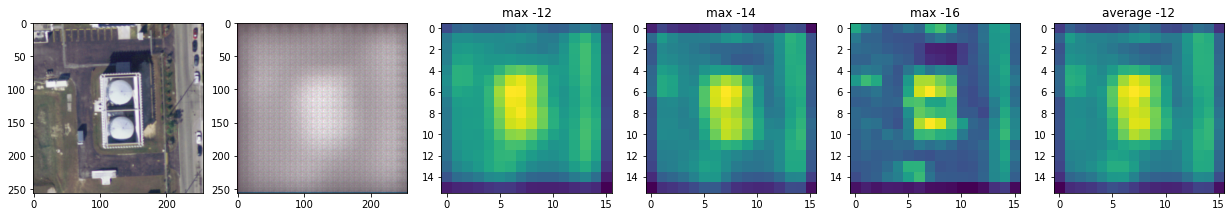

Model: "functional_117"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
re_lu_55 (ReLU)              (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 64, 64, 48)        13872     
_________________________________________________________________
re_lu_56 (ReLU)              (None, 64, 64, 48)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 32, 32, 72)        31176     
_________________________________________________________________
re_lu_57 (ReLU)              (None, 32, 32, 72)     

In [45]:
encoder = trainNewEncoder('/content/data/train/train_data_dir', '/content/data/val/val_data_dir')
encoder.summary()

In [12]:
# Fully Connected Layer
def fc(enco):
    flat = Flatten()(enco)
    den = Dense(128, activation='relu')(flat) 
    out = Dense(2, activation='softmax')(den)
    return out

def tempModel(dims) :
  tempModel = Conv2D(filters = 10, kernel_size = (3, 3), activation='relu', padding="same", strides=(2, 2))(dims)
  tempModel = Conv2D(filters = 2, kernel_size = (3, 3), activation='relu', padding="same", strides=(2, 2))(tempModel)
  #print(tempModel.shape)

  tempModel = UpSampling2D(size=(2, 2))(tempModel)
  tempModel = Conv2D(filters = 2, kernel_size = (3, 3), activation='relu', padding="same")(tempModel)
  tempModel = UpSampling2D(size=(2, 2))(tempModel)
  tempModel = Conv2D(filters = 2, kernel_size = (3, 3), activation='relu', padding="same")(tempModel)
  tempModel = Conv2D(filters = 2, kernel_size = (3, 3), padding="same")(tempModel)
  return tempModel
 

input_img = Input(shape = (256, 256, 3))
encode = tempModel(input_img)
full_model = Model(input_img,fc(encode))

In [13]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(256, 256))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_net.preprocess_input(x)
        #x = x.reshape(1, 32*32*3)
        #print(x.shape, x.ndim) 
        out.append(x)
    return np.vstack(out)
  
# Let's look at an example image.
images = transform_img_fn(['/content/data/train/train_data_dir/harbor/harbor00.tif'])

#plt.imshow(images[0] / 2 + 0.5)
preds = encoder.predict(images)
#print(preds)

In [14]:
##########################
### == MOST DIVERSE == ###
##########################
def extract_features(img_path, model):
    input_shape = (256, 256, 3)
    img = image.load_img(img_path, target_size=(
        input_shape[0], input_shape[1]))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    #preprocessed_img = preprocess_input(expanded_img_array)
    features = model.predict(expanded_img_array) # used to be preprocessed_img
    flattened_features = features.flatten()
    normalized_features = flattened_features / norm(flattened_features)
    return normalized_features
def bruteDiverseEmbeddings(n, filenames, feature_list):
  filenameCopy = filenames.copy()
  setInput = feature_list.copy()
  setOutput = []
  filenameOutput = []
  idx = random.randint(0, len(setInput))
  setOutput.append(setInput[idx])
  filenameOutput.append(filenameCopy[idx])
  distance = [0] * len(setInput)
  for _ in range(n - 1) :
    for i in range(len(setInput)) :
        distance[i] += np.linalg.norm(setInput[i] - setOutput[-1])
    inds =  distance.index(max(distance))
    setOutput.append(setInput[inds])
    filenameOutput.append(filenameCopy[inds])
    del setInput[inds]
    del filenameCopy[inds]
    del distance[inds]
  return filenameOutput, setOutput, distance

# The goal here is to create a function that takes in a model, a dataset, and a training limit, and 
# creates a directory of diverse training images for an encoder to train on 

# model = encoder, dataset = dir of dataset in string, trainingLimit = int
def createDirOfDiverse(encoder, dataset_dir, training_dir, trainingLimit) :

    img_dirs = getPathsOfData([dataset_dir])
    img_dirs.sort()

    embeddings = []
    for dir in img_dirs :
        embeddings.append(extract_features(dir, encoder))
    printTSNEPlot(img_dirs, embeddings, getClassColors(img_dirs))

    diverseNames, diverseEmbeddings, _ = bruteDiverseEmbeddings(trainingLimit, img_dirs, embeddings)
    printTSNEPlot(diverseNames, diverseEmbeddings, getClassColors(diverseNames))

In [15]:
def plot_images_in_2d(x, y, image_paths, axis=None, zoom=1):
    if axis is None:
        axis = plt.gca()
    x, y = np.atleast_1d(x, y)
    for x0, y0, image_path in zip(x, y, image_paths):
        image = Image.open(image_path)
        image.thumbnail((100, 100), Image.ANTIALIAS)
        img = OffsetImage(image, zoom=zoom)
        anno_box = AnnotationBbox(img, (x0, y0),
                                  xycoords='data',
                                  frameon=False)
        axis.add_artist(anno_box)
    axis.update_datalim(np.column_stack([x, y]))
    axis.autoscale()

def show_tsne(x, y, selected_filenames):
    fig, axis = plt.subplots()
    fig.set_size_inches(20, 20, forward=True)
    plot_images_in_2d(x, y, selected_filenames, zoom=0.3, axis=axis)
    plt.show()

def tsne_to_grid_plotter_manual(x, y, selected_filenames):
    S = 2000
    s = 100
    x = (x - min(x)) / (max(x) - min(x))
    y = (y - min(y)) / (max(y) - min(y))
    x_values = []
    y_values = []
    filename_plot = []
    x_y_dict = {}
    for i, image_path in enumerate(selected_filenames):
        a = np.ceil(x[i] * (S - s))
        b = np.ceil(y[i] * (S - s))
        a = int(a - np.mod(a, s))
        b = int(b - np.mod(b, s))
        if str(a) + "|" + str(b) in x_y_dict:
            continue
        x_y_dict[str(a) + "|" + str(b)] = 1
        x_values.append(a)
        y_values.append(b)
        filename_plot.append(image_path)
    fig, axis = plt.subplots()
    fig.set_size_inches(20, 20, forward=True)
    plot_images_in_2d(x_values, y_values, filename_plot, zoom=.58, axis=axis)
    plt.show()


def printTSNEPlot(filenames, embeddings, colors) :
    num_features = 100
    pca = PCA(n_components = num_features)
    pca.fit(embeddings)
    embeddings_compressed = pca.transform(embeddings)

    selected_features = embeddings_compressed
    selected_class_ids = colors
    selected_filenames = filenames

    plt.figure()
    tsne_results = TSNE(n_components=2,verbose=1,metric='euclidean').fit_transform(selected_features)
    colormap = plt.cm.get_cmap('coolwarm')
    scatter_plot = plt.scatter(tsne_results[:,0],tsne_results[:,1], c = selected_class_ids, cmap=colormap)
    plt.colorbar(scatter_plot) 
    plt.show()

    show_tsne(tsne_results[:, 0], tsne_results[:, 1], selected_filenames)

In [16]:
'''trainingLimit = 300
createDirOfDiverse(encoder, 
                   '/content/data/train/train_data_dir',
                   '/content/data/val/val_data_dir',
                   trainingLimit)'''

"trainingLimit = 300\ncreateDirOfDiverse(encoder, \n                   '/content/data/train/train_data_dir',\n                   '/content/data/val/val_data_dir',\n                   trainingLimit)"

In [17]:
def getNClosestImages(sample_embedding, embeddings, img_dirs, num_closest, includeOriginal = True) :
    distances = np.zeros(len(embeddings))
    img_dirs = np.array(img_dirs)

    for i in range(len(embeddings)) :
        distances[i] = np.linalg.norm(sample_embedding - embeddings[i])

    inds = distances.argsort()

    distances = distances[inds]
    img_dirs = img_dirs[inds]

    return img_dirs[:num_closest], distances[:num_closest]

def printClosestImages(encoder, dataset_dir, num_samples, num_closest) :
    # get list of images
    img_dirs = getPathsOfData([dataset_dir])

    # get embeddings of images
    embeddings = []
    for dir in tqdm(img_dirs) :
        embeddings.append(extract_features(dir, encoder))

    # select random num_smaples of images
    sample_imgs = random.sample(img_dirs, num_samples)

    sample_embeddings = []
    for img in sample_imgs :
        sample_embeddings.append(embeddings[img_dirs.index(img)])
    

    # find the nearest num_closest images to each sample image and return in 1D array (helper function)
    sample_similar = []
    sample_distances = []
    for sample in sample_embeddings :
        dirs, distances = getNClosestImages(sample, embeddings, img_dirs, num_closest)
        sample_similar.append(dirs)
        sample_distances.append(distances)
    
    # print the 2D array (helper function)
    fig = plt.figure(figsize = (18, 14))
    for i in range(num_samples) :
        c = 0
        images = transform_img_fn(sample_similar[i])
        preds = encoder.predict(images)
        for j in range(num_closest) :
            class_name = sample_similar[i][j][sample_similar[i][j].rindex('/') + 1:-4]
            explainer = lime_image.LimeImageExplainer()
            explanation = explainer.explain_instance(images[j], full_model.predict, top_labels=5, hide_color=0, num_samples=1000)
            temp, mask = explanation.get_image_and_mask(1, positive_only=False, num_features=10, hide_rest=False) 

            sub = plt.subplot(num_samples, num_closest * 2, 1 + c + num_closest * i * 2)

            sub.set_title(class_name + '  ' + str(round(sample_distances[i][j], 4)))
            plt.imshow(plt.imread(sample_similar[i][j]))
            c += 1

            sub = plt.subplot(num_samples, num_closest * 2, 1 + c + num_closest * i * 2)

            #sub.set_title(class_name + '  ' + str(round(sample_distances[i][j], 4)))
            plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
            c += 1


            ## swappable: gray image code ##
            #temp, mask = explanation.get_image_and_mask(1, positive_only=True, num_features=5, hide_rest=True)
            #plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
            
    plt.show()

100%|██████████| 2100/2100 [01:28<00:00, 23.60it/s]


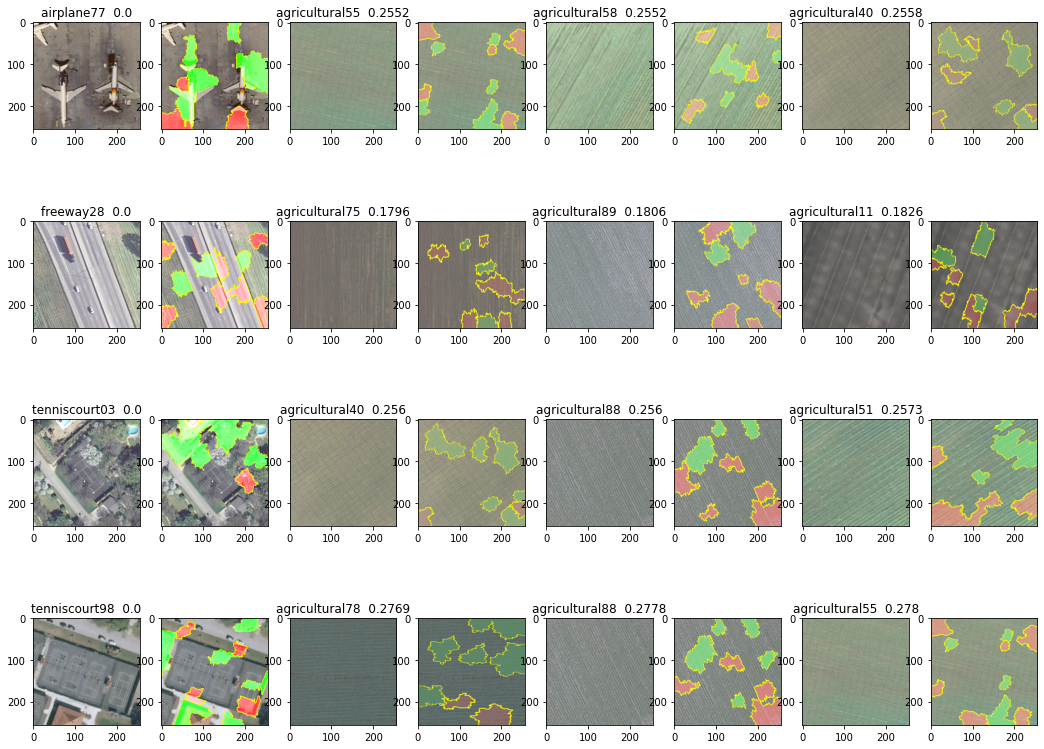

In [18]:
printClosestImages(encoder, '/content/data/UCMerced_LandUse/Images', 4, 4)   #rows, columns 

In [19]:
%matplotlib inline
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

def createUMAP_PCA(dataset_dir, encoder):
    img_dirs = getPathsOfData([dataset_dir])
    embeddings = []
    for dir in tqdm(img_dirs) :
        embeddings.append(extract_features(dir, encoder))

    num_features = 100
    pca = PCA(n_components = num_features)
    pca.fit(embeddings)
    embeddings_compressed = pca.transform(embeddings)

    standard_embedding = umap.UMAP(random_state=42).fit_transform(embeddings_compressed)
    plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=getClassColors(img_dirs), s=10, cmap='nipy_spectral')
    plt.title('UMAP embedding with PCA');

def createUMAP_reg(dataset_dir, encoder):
    img_dirs = getPathsOfData([dataset_dir])
    embeddings = []
    for dir in tqdm(img_dirs) :
        embeddings.append(extract_features(dir, encoder))

    standard_embedding = umap.UMAP(random_state=42).fit_transform(embeddings)
    plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=getClassColors(img_dirs), s=10, cmap='nipy_spectral')
    plt.title('UMAP embedding without PCA');

100%|██████████| 2100/2100 [01:29<00:00, 23.40it/s]


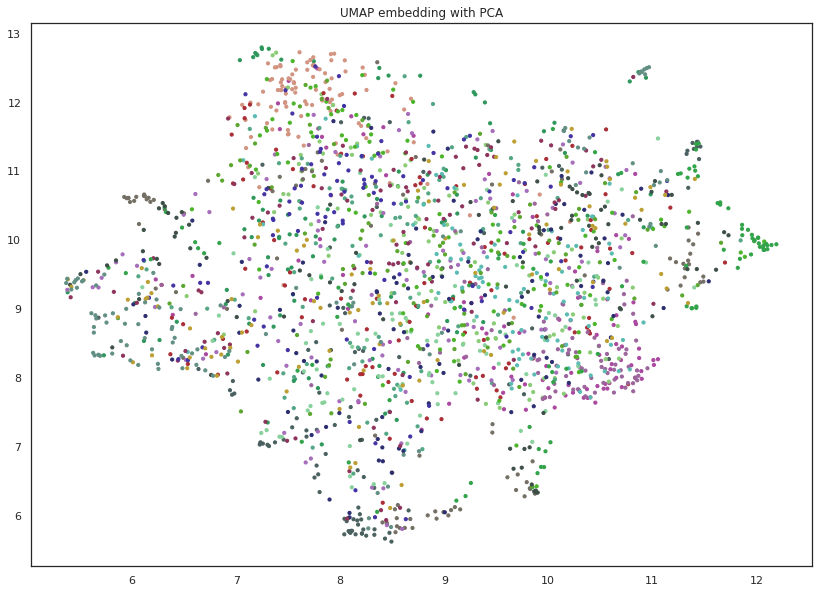

In [20]:
createUMAP_PCA('/content/data/UCMerced_LandUse/Images', encoder)